In [19]:
import warnings
warnings.filterwarnings('ignore')                                      # 경고 무시

import numpy as np                                                     # numpy라이브러리 불러오기
import pandas as pd                                                    # pandas 라이브러리 불러오기
import matplotlib.pyplot as plt                                        # matplotlib.pyplot 라이브러리 불러오기
import os                                                              # 환경변수에 접근하기 위해 os 라이브러리 불러오기

from statsmodels.tsa.stattools import adfuller                         # adf test 라이브러리 불러오기

from statsmodels.tsa.seasonal import seasonal_decompose                # 시계열 분해 (Time Series Decomposition)
                                                                       # 시계열 안에 존재하는 trend, seasonality를 직접 분리해 낼 수 있는 기능

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf          # ACF, PACF 그려보기 -> p,q 구하기

from statsmodels.tsa.arima.model import ARIMA                          # ARIMA 모델 라이브러리 불러오기


from sklearn.metrics import mean_squared_error, mean_absolute_error    # MSE, MAE 라이브러리 불러오기. 성능 평가용
import math                                                            # math 라이브러리 불러오기

from matplotlib.pylab import rcParams                                  # pylab 라이브러리 불러오기
rcParams['figure.figsize'] = 13, 6                                   # matlab 차트의 기본 크기를 13, 6으로 지정해 줍니다.

# STEP 1 : 시계열 데이터 준비

- 칼럼 종류: Date, Open, High, Low, Close, Adj Close, Volume
- 날짜별로 시작가(Open), 최고가(High), 최저가(Low), 종가(Close), 수정종가(Adj Close), 거래량(Volume)이 저장되어 있는 것을 확인할 수 있습니다.
- 우리는 종가(Close)만 사용하겠습니다. (주식 시장은 정해진 시간 동안만 거래가 가능합니다. 종가란 하루의 장이 마감하였을 때의 가격입니다.)


In [20]:
# Time Series 생성
dataset_filepath = os.getenv('HOME') + '/aiffel/stock_prediction/data/GOOGL.csv'
df = pd.read_csv(dataset_filepath, index_col='Date', parse_dates=True)
ts = df['Close']

ts.head(10)

Date
2021-09-21    139.033005
2021-09-22    140.283493
2021-09-23    141.216003
2021-09-24    142.214996
2021-09-27    141.072006
2021-09-28    135.830002
2021-09-29    134.353500
2021-09-30    133.675995
2021-10-01    136.542999
2021-10-04    133.659500
Name: Close, dtype: float64

# STEP 2 : 각종 전처리 수행



- 결측치 처리
- 로그 변환

## 2.1 결측치 처리

In [21]:
# 결측치 존재 확인
ts[ts.isna()]                       # 결측치가 있는 행 출력
                                    # 출력 결과 결측치 없음

Series([], Name: Close, dtype: float64)

In [22]:
# 결측치 처리
# 결측치 확인하여 결측치 없었지만 그래도 다음 모델 확인을 위해 남겨둠

ts = ts.interpolate(method='time')  # 결측치가 있다면 이를 보간합니다. 보간 기준은 time을 선택합니다. 

ts[ts.isna()]                       # Time Series에서 결측치가 있는 부분만 Series로 출력합니다.

Series([], Name: Close, dtype: float64)

## 2.2 로그 변환

### 2.2.1 원본 시계열 시각화

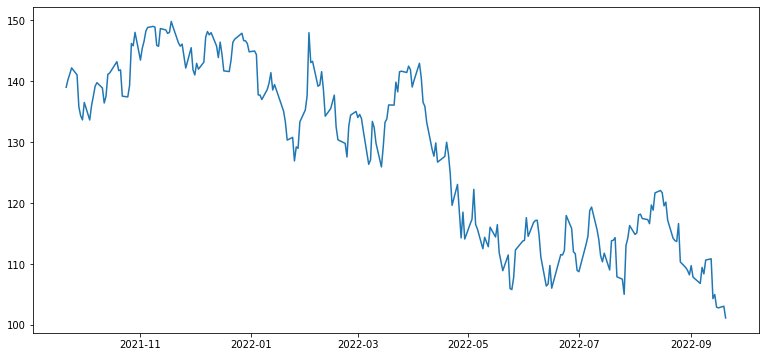

In [23]:
# 원본 TimeSeries 데이터 시각화
plt.plot(ts)                             # 시각화해보니 stationary가 아님
                                         # 분산, 공분산 일정하지 않음 -> Non-stationary

### 2.2.2 로그 변환(Log Transformation)

In [24]:
# 로그 변환 시도 
# 원본 시계열이 Non_stationary하기 때문에 일단 로그 변환시켜 위아래 폭을 줄임
ts_log = np.log(ts)                

# STEP 3 : 시계열 안정성 분석

- 정성적 그래프 분석
- 정량적 Augmented Dicky-Fuller Test
- 시계열 분해(Time Series Decomposition)
- Residual 안정성 확인




## 3.1 정성적 그래프 분석

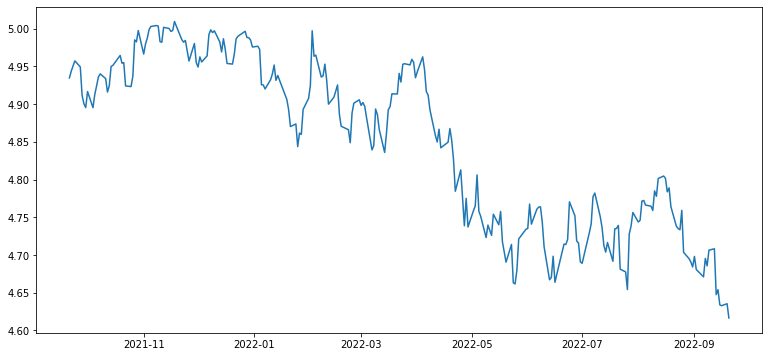

In [25]:
# 확인용
plt.plot(ts_log)

로그 변환해도 차이가 없음. 따라서 추가적으로 데이터 전처리 하겠음


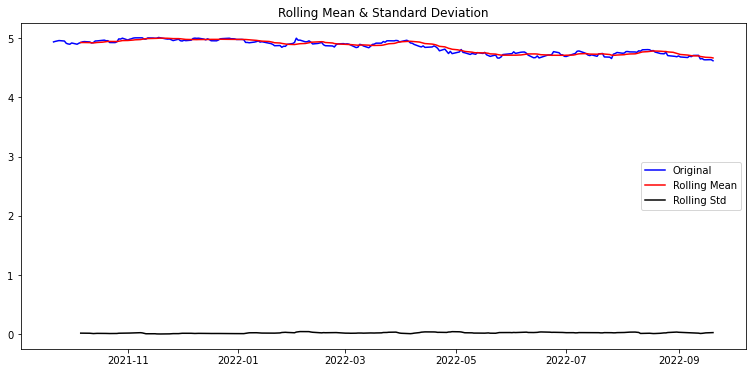

In [26]:
# 구간 통계치(Rolling Statistics) MA, STD의 그래프 그리기 함수 정의
def plot_rolling_statistics(timeseries, window=12):
    
    rolling_mean = timeseries.rolling(window=window).mean()                 # 이동평균(MA) 시계열
    rolling_std = timeseries.rolling(window=window).std()                   # 이동표준편차 시계열

    # 원본시계열, 이동평균, 이동표준편차를 plot으로 시각화해 본다.

    orig = plt.plot(timeseries, color='blue',label='Original')              # 원본   
    mean = plt.plot(rolling_mean, color='red', label='Rolling Mean')        # MA
    std = plt.plot(rolling_std, color='black', label='Rolling Std')         # STD
    
    plt.legend(loc='best')                                                  # 범례
    plt.title('Rolling Mean & Standard Deviation')                          # 제목
    plt.show(block=False) 
    
    
# 정성적 그래프 분석 그리기
plot_rolling_statistics(ts_log, window=12)                                  # 이동평균의 계산에 12 이전 데이터 단위로 계산요청

## 3.2 정량적 Augmented Dicky-Fuller Test - Stationary 유무 확인

In [27]:
# ADF Test는 해당 시계열 데이터가 "Stationary"인지 통계량을 출력하면 사용자가 P-value 등을 확인하여 Stationary 유무 확인
def augmented_dickey_fuller_test(timeseries):
   
    # statsmodels 패키지에서 제공하는 adfuller 메서드를 호출합니다.
    dftest = adfuller(timeseries, autolag='AIC')  
    
    # adfuller 메서드가 리턴한 결과를 정리하여 출력합니다.
    print('Results of Dickey-Fuller Test:')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    
    # 위 pd.Series로 4번 인덱스 "딕셔너리"에 있는 정보를 리스트만으로 넣어줄 수 없어서 아래 구문으로 추가로 넣어줌
    for key,value in dftest[4].items():                                # 4번 인덱스는 "딕셔너리"
        dfoutput['Critical Value (%s)' % key] = value                  # 문자열 % 서식지정자  구문
                                                                       # 시리즈이면 serise['이름'] = 값 형태는 해당 인덱스에 값을 부여
    print(dfoutput)
    

# 정량적 Augmented Dicky-Fuller Test로 Stationary 확인하기
augmented_dickey_fuller_test(ts_log)

Results of Dickey-Fuller Test:
Test Statistic                  -0.938068
p-value                          0.775178
#Lags Used                       0.000000
Number of Observations Used    251.000000
Critical Value (1%)             -3.456674
Critical Value (5%)             -2.873125
Critical Value (10%)            -2.572944
dtype: float64


> ts_log는 p-value가 5%보다 훨씬 높기 때문에 stationary하지 않다. 

- 시계열 분리하여 추세와 계절성을 없앤 residual을 만들어 확인해볼것임
- 시계열 분리에서도 p-value가 높으면 차분(differencing)을 진행해서 stationary하도록 맞춰줄것이다

##  3.3 시계열 분해 (Time Series Decomposition)

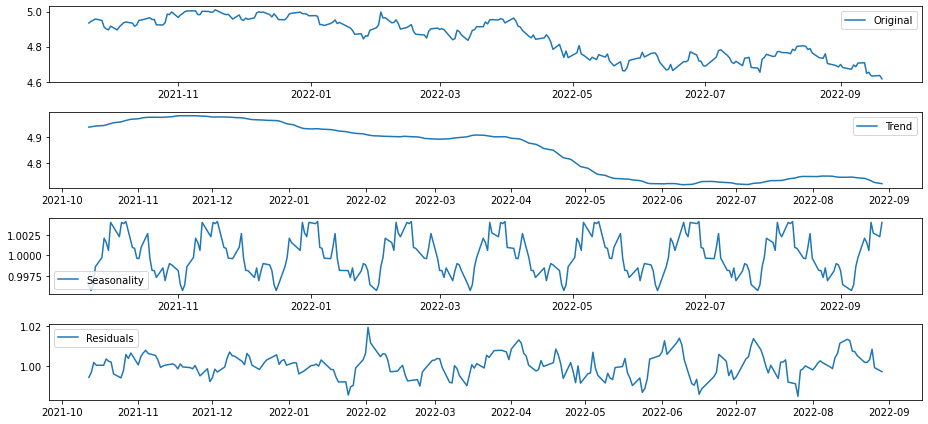

In [28]:
# 시계열 분해 (Time Series Decomposition)
# Non-stationary 데이터를 Stationary로 변환하는 방법은 차분, 추세 없애기, 계절성 없애기가 있다. 여기서는 시계열을 추세, 계절을 추출하고 원본에서 뺸다음 잔여물 최종결과의 Stationary 확인해본다
decomposition = seasonal_decompose(ts_log, model='multiplicative', period = 30)     # 시계열 안에 존재하는 trend, seasonality를 직접 분리해 낼 수 있는 기능
                                                                                    # seasonal_decompose 라이브러리 이용
trend = decomposition.trend                                                         # 추세(시간 추이에 따라 나타나는 평균값 변화 )
seasonal = decomposition.seasonal                                                   # 계절성(패턴이 파악되지 않은 주기적 변화)
residual = decomposition.resid                                                      # 원본(로그변환한) -(빼기) 추세 -(빼기) 계절성

# 분해된 시계열 각각 그리기
plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')

plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')

plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')

plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')

plt.tight_layout()

> 마지막 Residual을 확인하면 추세도 없고, 계절성, 주기성도 없는 Stationary 데이터셋인 것을 확인할 수 있다.  
더 확실하기 위해 아래에서 정량적으로 확인한다

## 3.4 Residual 안정성 확인

시계열 분해로 얻은 Residual을 ADF-Test로 P-value가 5%안에 들어와 귀무가설을 기각하는지 확인함

Results of Dickey-Fuller Test:
Test Statistic                -6.237460e+00
p-value                        4.786777e-08
#Lags Used                     2.000000e+00
Number of Observations Used    2.190000e+02
Critical Value (1%)           -3.460567e+00
Critical Value (5%)           -2.874830e+00
Critical Value (10%)          -2.573853e+00
dtype: float64


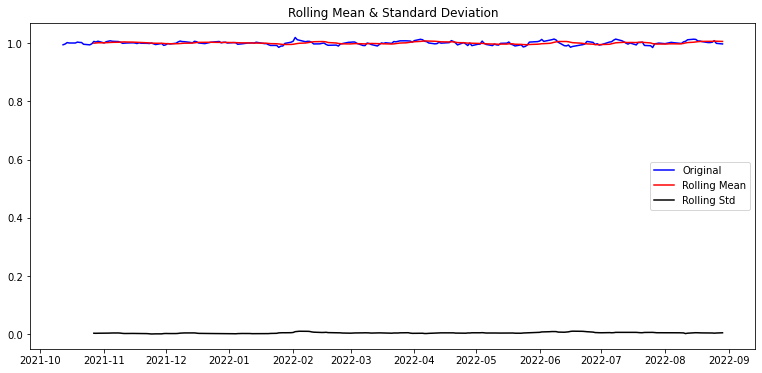

In [29]:
# Residual 안정성 확인
residual.dropna(inplace=True)                         # 결측치 제거    
augmented_dickey_fuller_test(residual)                # ADF-test로 Stationary 검증

plt.rcParams["figure.figsize"] = (13,6)               # 도화지 그리기 
plot_rolling_statistics(residual)                     # residual로 확인

> P-value가 0에 가깝게 도출되어 5% 이하가 됐기 때문에 귀무가설이 기각됐음으로 판단함. 따라서 대립가설이 참이되어 이 데이터셋 rediual은 Stationary라고 할 수 있다

지금까지 데이터를 Stationary로 만드는 과정이었다. 다음음 ARIMA 모델을 활용하여 주가를 최대한 적절하게 예측해보겠다

# STEP 4 : 학습, 테스트 데이터셋 생성
## 학습, 테스트 데이터셋 분리

시계열 예측이니 가장 마지막 데이터셋을 테스트용으로 사용하는 것이 타당함

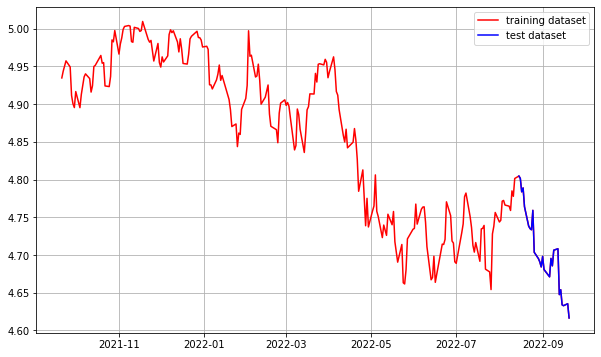

In [30]:
train_data, test_data = ts_log[:int(len(ts_log)*0.9)], ts_log[int(len(ts_log)*0.9):]  # 마지막 10퍼센트를 테스트용으로 설정
plt.figure(figsize=(10,6))                                                            # 도화지 생성   
plt.grid(True)                                                                        # 그리드 생성
# plt.plot(train_data, c='r', label='training dataset')                                 # train_data의 마지막 값과 test_data의 첫번쨰값을 그래프 그리기 원리상 이어주지 못함
                                                                                      # 만약 두 값을 한 그래프 plt로 했다면 그려줬을 거임 
plt.plot(ts_log, c='r', label='training dataset')                                   # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택

plt.plot(test_data, c='b', label='test dataset')
plt.legend()

In [31]:
# 확인용
print(ts_log[:2])
print()
print(train_data.shape)
print(test_data.shape)

Date
2021-09-21    4.934711
2021-09-22    4.943665
Name: Close, dtype: float64

(226,)
(26,)


# STEP 5 : 적정 ARIMA 모수 찾기
- ACF, PACF 그려보기 -> p,q 구하기
- 차분 안정성 확인 -> d 구하기

## 5.1 ACF, PACF 그리기

### ACF, PACF로 p, q를 결정
ACF와 PACF 그래프 해석으로 ARIMA모델 학습에 사용될 p, q를 결정(물론 정확한 것은 아니기 때문에 값을 변경하면서 테스트 해봐야 함)

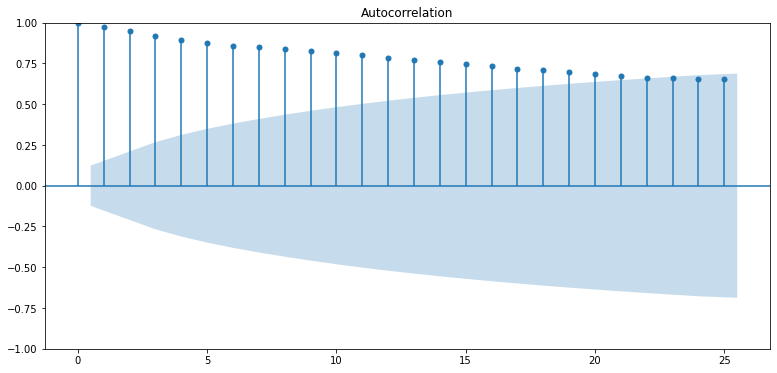

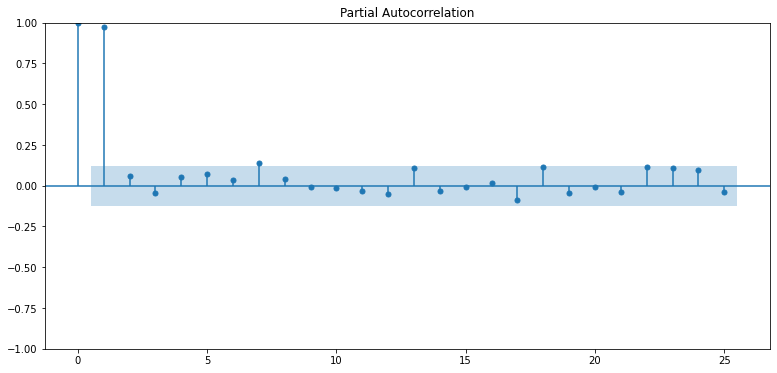

In [32]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf    # acf, pacf 라이브러리 불러오기

plot_acf(ts_log)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(ts_log)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()


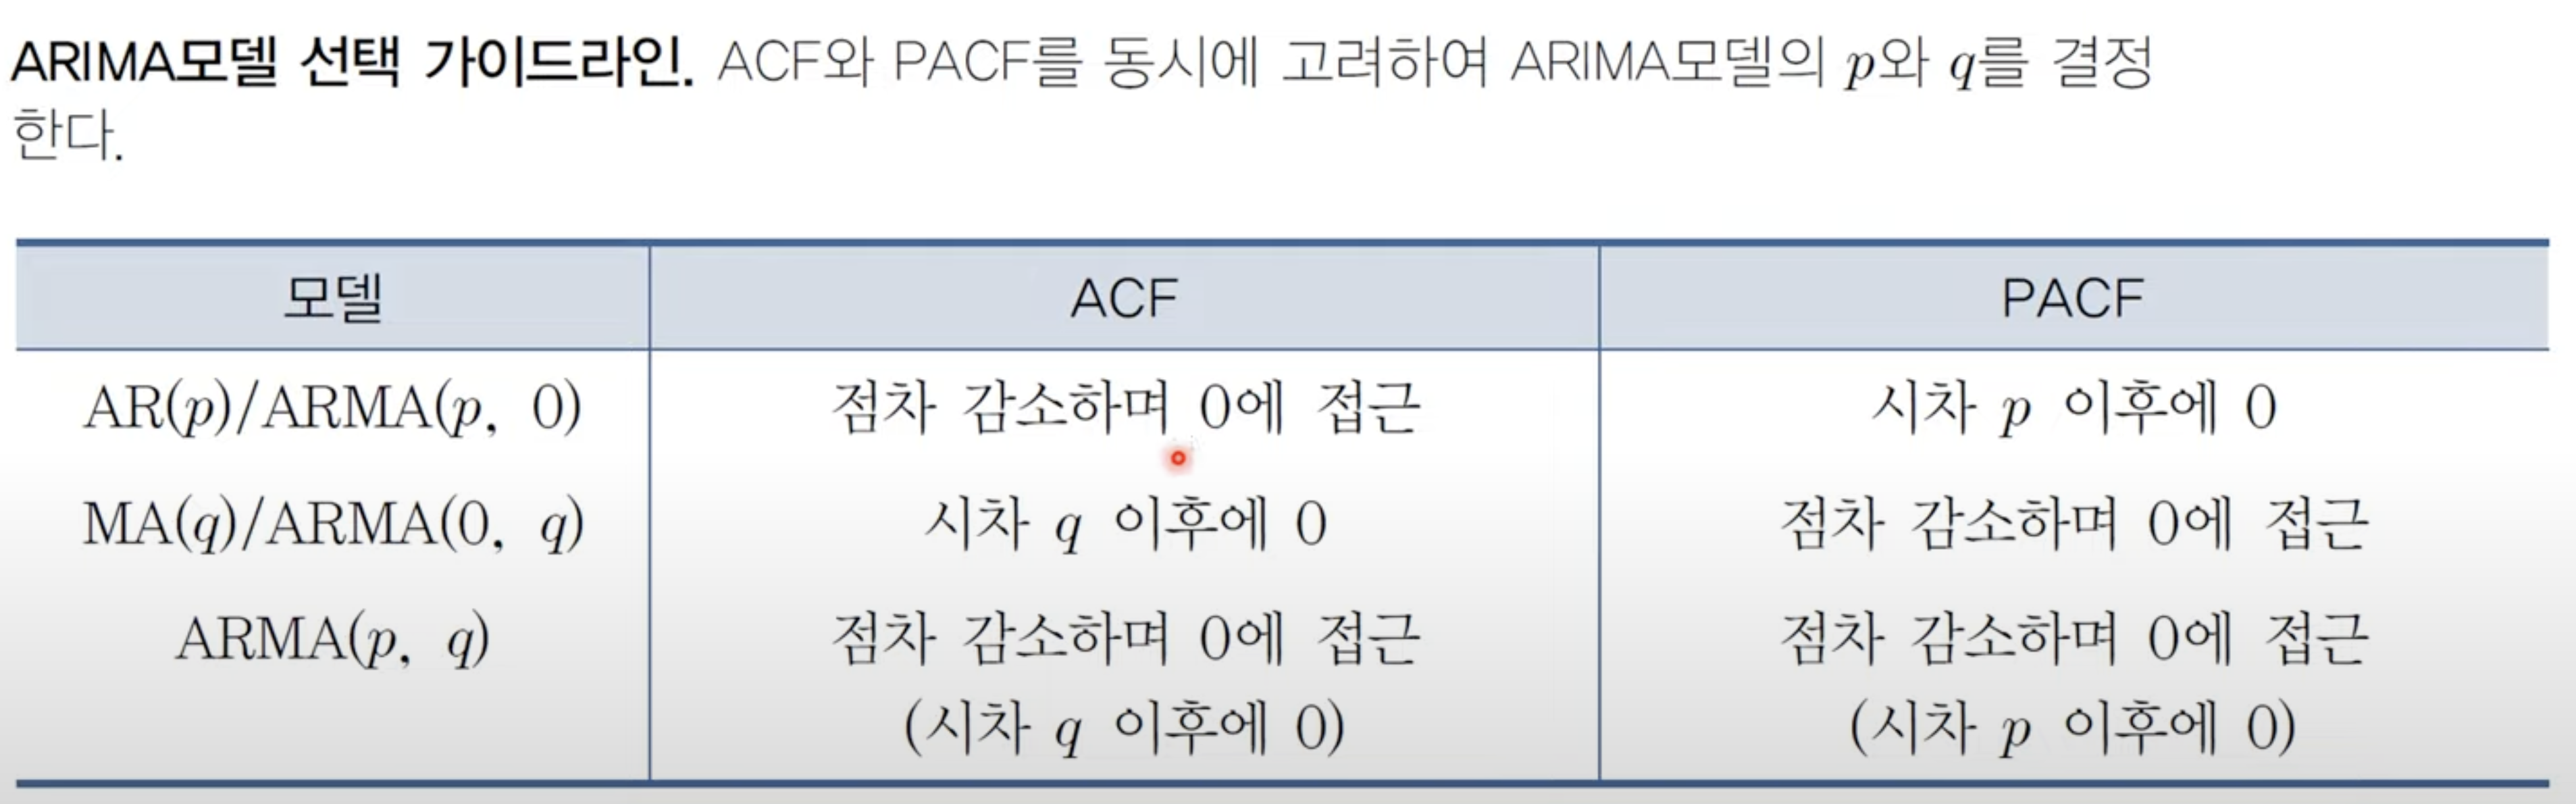

### p결정
- PACF에서 시차(x축) p이후 자기상관(y축)이 0이 되고, ACF에서 점차 감소하여 0에 접근하므로 두 조건을 만족하는 시차 p는 2이다 

### q결정
- ACF에서 시차(x축) p이후 자기상관(y축)이 0이 되고, PACF에서 점차 감소하여 0에 접근하므로 두 조건을 만족하는 시차 p는 21이다 
- 14라는 수는 너무 크기 때문에 테스트 과정에서 적절한 p를 시험해서 찾아 볼 것이다



## 5.2 차분(Differencing)하기

### 1차 차분

Results of Dickey-Fuller Test:
Test Statistic                -1.687694e+01
p-value                        1.070262e-29
#Lags Used                     0.000000e+00
Number of Observations Used    2.500000e+02
Critical Value (1%)           -3.456781e+00
Critical Value (5%)           -2.873172e+00
Critical Value (10%)          -2.572969e+00
dtype: float64


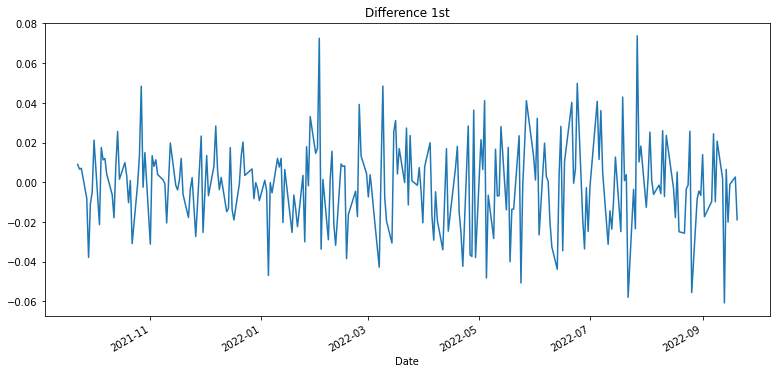

In [33]:
# 차분 안정성 확인 -> d 구하기
# 1차 차분 구하기
diff_1 = ts_log.diff(periods=1).iloc[1:]        # 1 lag 차분은 0번지 원소에 결측치를 남기므로 이상없는 데이터를 1행부터 슬라이싱 했음
diff_1.plot(title='Difference 1st')             # 1차 차분 데이터 그래프 시각화

augmented_dickey_fuller_test(diff_1)            # ADF-Test로 데이터셋이 stationary인지 확인 



> p-values는 거의 0이므로 1차 차분으로도 충분

### 2차 차분

Results of Dickey-Fuller Test:
Test Statistic                -7.696059e+00
p-value                        1.378360e-11
#Lags Used                     1.400000e+01
Number of Observations Used    2.350000e+02
Critical Value (1%)           -3.458487e+00
Critical Value (5%)           -2.873919e+00
Critical Value (10%)          -2.573367e+00
dtype: float64


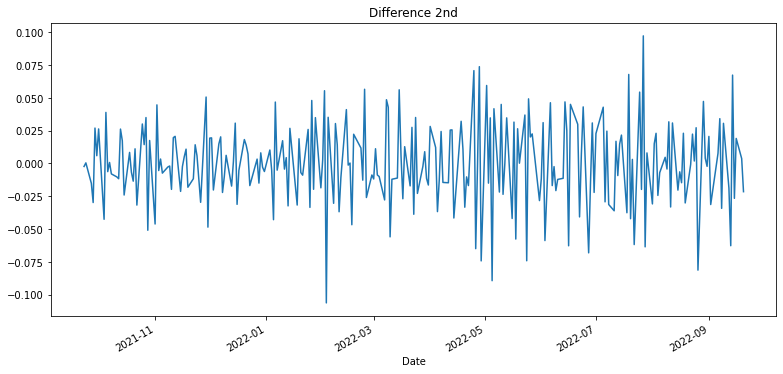

In [34]:
# 혹시 필요한 경우 2차 차분 구하기

diff_2 = diff_1.diff(periods=1).iloc[1:]          # 1 lag 차분된 데이터에서 다시 1 lag 차분은 0번지 원소에 결측치를 남기므로 이상없는 데이터를 1행부터 슬라이싱 했음
diff_2.plot(title='Difference 2nd')               # 2차 차분 데이터 그래프 시각화

augmented_dickey_fuller_test(diff_2)              # ADF-Test로 데이터셋이 stationary인지 확인 

> 1차 차분으로도 Stationary하므로 2차 차분은 진행하지 않았습니다

In [47]:
# 확인용
diff_1

Date
2021-09-22    0.016732
2021-09-23    0.006697
2021-09-24    0.000613
2021-09-27   -0.010606
2021-09-28   -0.024089
                ...   
2022-09-14    0.009510
2022-09-15   -0.019111
2022-09-16   -0.011021
2022-09-19    0.024774
2022-09-20    0.015544
Name: Close, Length: 251, dtype: float64

# STEP 6 : ARIMA 모델 훈련과 테스트

- ARIMA 모델 빌드와 훈련
- 모델 테스트 및 플로팅
- 최종 예측 모델 정확도 측정(MAPE)



자기상관관계가 있는 데이터를 가지고 ARIMA 모델을 설정 
-> ARIMA모델은 잔차를 도출함 
-> 그 잔차를 이용하여 관리함 or 표준편산출에 활용
 

## 6.1 AIRMA 학습

In [63]:
# Build and Train  Model
model = ARIMA(train_data, order=(14, 1, 0))                 # ARIMA 모델 라이브러리 사용
                                                           # p, d, q 각각 2, 0, 1 설정
                                                           # p : AutoRegression(AR)의 시차
                                                           # d : 차분 누적(Integration)
                                                           # q : 이동평균 모형(MA)의 시차

fitted_m = model.fit()                                     # AIRMA 모델 학습

print(fitted_m.summary())                                  # 학습 요약 

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  226
Model:                ARIMA(14, 1, 0)   Log Likelihood                 546.678
Date:                Wed, 21 Sep 2022   AIC                          -1063.356
Time:                        13:43:57   BIC                          -1012.115
Sample:                             0   HQIC                         -1042.675
                                - 226                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0653      0.078     -0.841      0.400      -0.217       0.087
ar.L2          0.0045      0.070      0.064      0.949      -0.134       0.143
ar.L3         -0.1305      0.064     -2.042      0.0

In [ ]:
> 

## 6.2 예측

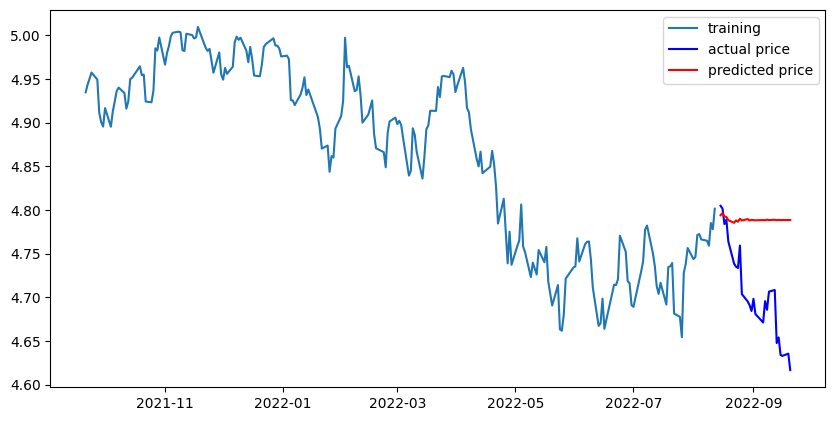

In [64]:
# Forecast : 결과가 fc에 담깁니다. 
fc = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf
fc = np.array(fc)                                   # numpy 배열로 변환

# Serisef로 변환
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.legend()
plt.show()

In [ ]:
> 

## 6.3 모델 성능 평가

In [65]:
mse = mean_squared_error(np.exp(test_data), np.exp(fc))                               # MSE 평가
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))                              # MAE 평가
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))                   # RMSE 평가
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))      # MAPE 평가
print('MAPE: {:.2f}%'.format(mape*100))


MSE:  122.73685139438831
MAE:  9.603745407121144
RMSE:  11.078666498924331
MAPE: 8.96%


- MAPE는 퍼센트 값을 가지며 0에 가까울수록 회귀 모형의 성능이 좋다고 해석할 수 있음
- MSE의 범위는 0~무한대(infinity)의 값을 가진다.
- MSE가 100이다 했을 때 이 모형이 좋은지 판단하기가 어려움 그래서 MAPE의 퍼센트 값을 통해 성능평가

> p 
MAPE : 1.03% 이므로 좋은 결과를 얻었음!

# STEP 7 : 다른 주식 종목 예측해 보기

> 다른 파일에 작성했습니다

# STEP 8: 회고

1. 이번 프로젝트에서 어려웠던 점 
    - 귀무가설, 대립가설, p-value에 대한 개념 이해가 어려웠지만 해결했습니다
    - ACF, PACF를 해석하는 방법이 어려웠습니다
    - ARIMA 학습 모델의 모수 p, d, q의 개념이 모호해서 이해하기 어려웠습니다
    - 공분산 계념이 어려웠습니다
    
2. 프로젝트를 진행하면서 알아낸 점 혹은 아직 모호한 점
    - ACF, PACF를 해석하는 방법
    - p, d, q의 개념
    - 공분산 개념

3. 루브릭 평가 지표를 맞추기 위해 시도한 것들
    - 차분 1, 2 넣어보고, ACF, PACF 그래프 보면서 p, d, q 확인하기
    - ARIMA 모델의 모수 선택 근거는. ACF, PACF. 그래도 안되면 차분을 최대 2까지 해보기. 그래도 안되면 p, q를 루프 돌려서 찾아보기
    
4. 만약에 루브릭 평가 관련 지표를 달성 하지 못했을 때, 이유에 관한 추정  
    - 달성함

    
5. 자기 다짐
     - 용어에 대한 개념 이해가 부족하니 전체 흐름에 대한 이해가 부족했습니다. 유튜브 동영상과 구글 검색으로 대략적인 흐름과 내용은 이해했으나 모수 선택과
    상관관계 그래프 해석이 어려웠습니다. 좀 더 명확하게 개념을 이해하도록 방법을 찾아봐야할 것 같고,, 그렇다고 너무 시간이 걸리는 방향은 자제해야겠다

    
